<a href="https://colab.research.google.com/github/RuperttAryeenWind/datascience/blob/master/machine-learning/courses/linkedin_ai/day2/GAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

~/anaconda3/bin/pip install pygam

conda update seaborn

In [1]:
%matplotlib inline
!pip install pygam
import pygam
import pandas
import numpy
import math
import seaborn
import matplotlib
import matplotlib.pyplot
import functools
import operator
import sklearn
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
print(seaborn.__version__)

     |████████████████████████████████| 1.8MB 4.7MB/s 
0.9.0


In [0]:
# try to kill optimizer warnings
# https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [0]:
numpy.random.seed(seed=2018)

def mk_example(minv, maxv, step):
    d = pandas.DataFrame({'x': numpy.arange(minv, maxv, step)})
    d['y_theoretical'] = [math.sin(1.1*x) for x in d['x']]
    return(d)
    
d = mk_example(0, 15, 0.2)
d['y'] = d['y_theoretical'] + 0.2*numpy.random.normal(0,1,len(d['y_theoretical']))
d['train'] = numpy.random.uniform(0,1,len(d['y_theoretical']))>=0.5

dtrain = d[d['train']].copy()
dexpanded = mk_example(-0.1, 15.1, 0.1)


In [0]:
d.head()

,x,y_theoretical,y,train
0,0.0,0.000000,-0.055354,False
1,0.2,0.218230,0.334600,False
2,0.4,0.425939,0.855619,False
3,0.6,0.613117,0.357219,False
4,0.8,0.770739,0.871194,True


In [0]:
d.describe()

,x,y_theoretical,y
count,75.000000,75.000000,75.000000
mean,7.400000,0.107504,0.089501
std,4.358899,0.690300,0.746389
min,0.000000,-0.999990,-1.290968
25%,3.700000,-0.537614,-0.618114
50%,7.400000,0.192422,0.210467
75%,11.100000,0.762205,0.850080
max,14.800000,0.999526,1.148148


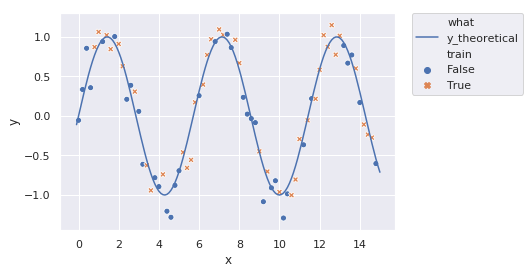

In [0]:
def plotf(dpts, dcurves, curves):
    seaborn.set(style="darkgrid")
    pd = dcurves.loc[:, ["x"] + curves]
    pd = pd.set_index("x")
    pd = pandas.DataFrame.unstack(pd)
    pd = pd.reset_index()
    pd = pd.rename(columns={"level_0": "what", "x": "x", 0:"y"})
    matplotlib.pyplot.clf()
    seaborn.lineplot(x="x", y="y", hue="what", data=pd)
    seaborn.scatterplot(x="x", y="y", hue="train", style="train", data=dpts)
    matplotlib.pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    matplotlib.pyplot.show()
    
plotf(d, dexpanded, ["y_theoretical"])

By hand polynomial fitting

In [0]:
def pfit(dtrain, deg):
    polyfit = sklearn.pipeline.Pipeline([('poly', sklearn.preprocessing.PolynomialFeatures(degree=deg)),
                ('linear', sklearn.linear_model.LinearRegression(fit_intercept=True))])
    polymodel = polyfit.fit(dtrain[['x']], dtrain['y'])
    return(polymodel)

In [0]:
degs = range(51)
for deg in degs:
    polymodel = pfit(dtrain, deg)
    dexpanded['poly_prediction_'+str(deg)] = polymodel.predict(dexpanded[['x']])

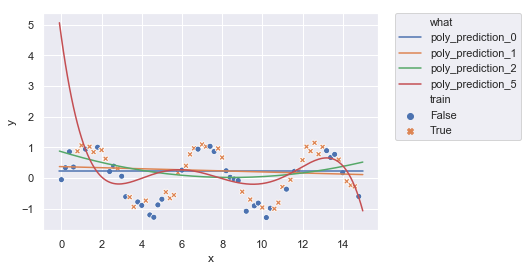

In [0]:
plotf(d, dexpanded, [ 'poly_prediction_' + str(deg) for deg in [0, 1, 2, 5]])

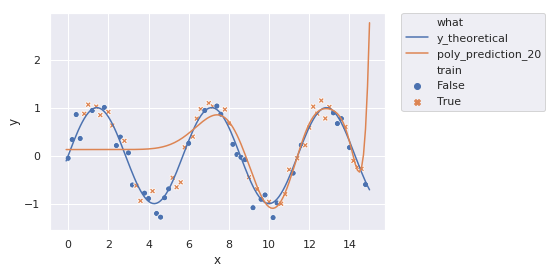

In [0]:
plotf(d, dexpanded, ["y_theoretical", "poly_prediction_20"])

In [0]:
def est_resid_i(dtain, fitfun, deg, i):
    n = dtrain.shape[0]
    dtei = dtrain.iloc[[i]]
    dtri = dtrain.iloc[[j for j in range(n) if i != j]]
    mdli = fitfun(dtri, deg)
    actual = numpy.asscalar(pandas.to_numeric(dtei["y"].iloc[0]))
    pred = numpy.asscalar(mdli.predict(dtei[['x']]))
    return(actual-pred)
    
def est_mean_sq_error(dtrain, fitfun, deg): 
    return(numpy.mean([est_resid_i(dtrain, fitfun, deg, i)**2 for i in range(dtrain.shape[0])]))

mean_sq_errors = [est_mean_sq_error(dtrain, pfit, deg) for deg in degs]
print(mean_sq_errors)
best_deg = degs[mean_sq_errors.index(min(mean_sq_errors))]
best_curve = 'poly_prediction_' + str(best_deg)
best_curve

[0.5395294572441509, 0.5578066189782168, 0.5445814432739825, 0.5316303144049433, 0.5604901108204674, 0.5241693139032445, 0.26821114053694717, 0.20367410435395272, 0.053095786715853355, 0.055753581512223725, 0.04983245933188593, 0.044366992776290734, 0.04205770012514017, 0.04024366151699195, 0.04615168756495213, 0.1009180483777808, 0.2876194637029896, 0.38837158805615307, 0.5658201207022215, 0.4187973419407277, 0.3100032731430145, 0.2737301474983349, 0.3234230405293047, 0.5245555588916352, 0.8283487615921876, 0.5836850147592073, 0.4751368947768466, 0.3653792717227315, 0.3172029583335384, 0.467623721000643, 1.0595259365302834, 2.472318900766653, 5.3007377343607, 10.34372570104979, 18.76818760954465, 32.673650177189415, 56.23612140764228, 78.26985509926493, 145.61733397844026, 233.962515636643, 90.8897017852239, 87.94764833431428, 113.2465816733539, 143.3679332230276, 178.4045380806326, 218.17748138405477, 262.1273864751641, 309.1976240396966, 357.33411768265154, 404.8738742975128, 447.27

'poly_prediction_13'

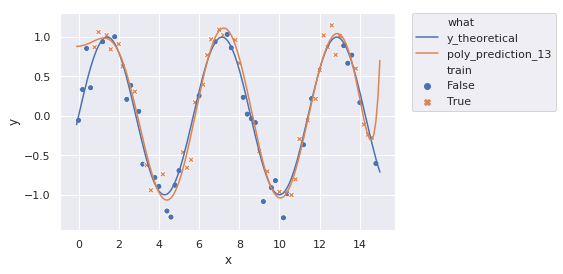

In [0]:
plotf(d, dexpanded, ["y_theoretical", best_curve])

Change our fitting strategy

In [0]:
def pfitr(dtrain, deg):
    polyfit = sklearn.pipeline.Pipeline([('poly', sklearn.preprocessing.PolynomialFeatures(degree=deg)),
                ('linear', sklearn.linear_model.Ridge(alpha = 1e-6, normalize=True, fit_intercept=True, solver = 'svd'))])
    polymodel = polyfit.fit(dtrain[['x']], dtrain['y'])
    return(polymodel)

In [0]:
degs = range(51)
for deg in degs:
    polymodel = pfitr(dtrain, deg)
    dexpanded['polyr_prediction_'+str(deg)] = polymodel.predict(dexpanded[['x']])

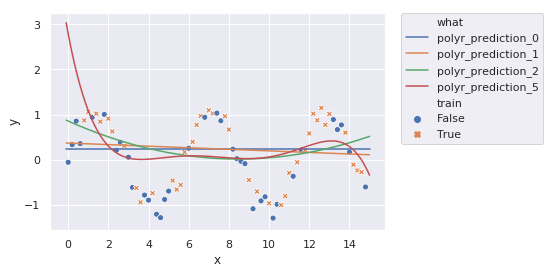

In [0]:
plotf(d, dexpanded, [ 'polyr_prediction_' + str(deg) for deg in [0, 1, 2, 5]])

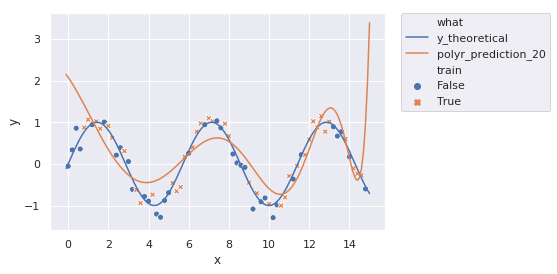

In [0]:
plotf(d, dexpanded, ["y_theoretical", "polyr_prediction_20"])

Pick a good fit by leave-one out holdout error estimate

In [0]:

mean_sq_errors = [est_mean_sq_error(dtrain, pfitr, deg) for deg in degs]
print(mean_sq_errors)
best_deg = degs[mean_sq_errors.index(min(mean_sq_errors))]
best_curve = 'polyr_prediction_' + str(best_deg)
best_curve

[0.5395294572441509, 0.5578065952122846, 0.5445804151280389, 0.5316087636174455, 0.558809043972915, 0.502267320153693, 0.4317049935328659, 0.3826370201183196, 0.37233409359917424, 0.40025978108426136, 0.4171676835047429, 0.39162265234946314, 0.33139101024898715, 0.263683210127851, 0.21369000859025392, 0.19155684007080698, 0.19231749571583123, 0.20417568636027267, 0.2162059618308345, 0.22172576962157725, 0.2185176646063897, 0.20782593781634234, 0.19309684666157867, 0.17874223086727223, 0.16901667884924157, 0.16711061301273356, 0.17456857060334813, 0.19109185471893628, 0.2147061967268359, 0.2422090338306785, 0.26977761365784186, 0.293616339686953, 0.3105383219498348, 0.31840237483968964, 0.3163577052098366, 0.3048818016315091, 0.2856297706553534, 0.2611411875797477, 0.2344683728213725, 0.2087942789564135, 0.18709867031311964, 0.1719116083318034, 0.16516955095449043, 0.1681679839822018, 0.18158988699816794, 0.20558303750448031, 0.23986006433303458, 0.28380064653648496, 0.33654246591112763

'polyr_prediction_42'

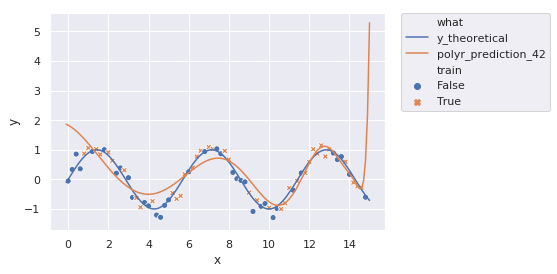

In [0]:
plotf(d, dexpanded, ["y_theoretical", best_curve])

GAM fitting

In [0]:
# help(pygam.LinearGAM)

In [0]:
model = pygam.LinearGAM().fit(dtrain[['x']], dtrain['y'])

In [0]:
dexpanded['gam_prediction'] = model.predict(dexpanded[['x']])

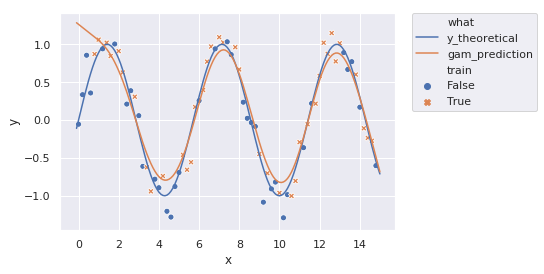

In [0]:
plotf(d, dexpanded, ["y_theoretical", "gam_prediction"])

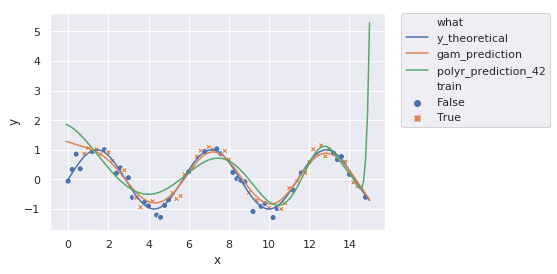

In [0]:
plotf(d, dexpanded, ["y_theoretical", "gam_prediction", best_curve])

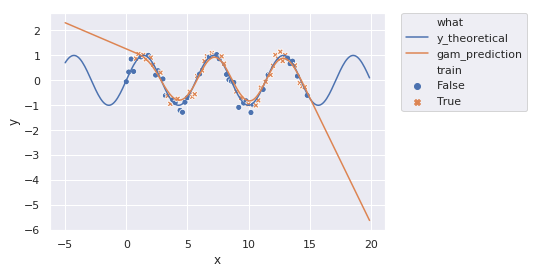

In [0]:
dexpanded = mk_example(-5, 20, 0.1)

dexpanded['gam_prediction'] = model.predict(dexpanded[['x']])

plotf(d, dexpanded, ["y_theoretical", "gam_prediction"])

Better features

In [0]:
dexpanded = mk_example(-5, 20, 0.1)

vars = []
for freq in [0.1, 0.25, 0.5, 1.0, 2.0, 4, 10]:
    for phase in [freq*offset for offset in [-1, -0.5, -0.25, 0, 0.25, 0.5, 1]]:
        vi = "sin((x+" + str(phase) + ")*" + str(freq) + ")"
        dexpanded[vi] = [ math.sin((x+phase)*freq) for x in dexpanded["x"] ]
        dtrain[vi] = [ math.sin((x+phase)*freq) for x in dtrain["x"] ]
        vars = vars + [vi]




In [0]:
n_row = dtrain.shape[0]

def mk_cross_plan(n, k):
    grp = [i % k for i in range(n)]
    numpy.random.shuffle(grp)
    plan = [ { "train"  : [i for i in range(n) if grp[i] != j],
               "test" : [i for i in range(n) if grp[i] == j] } for j in range(k) ]
    return(plan)

mk_cross_plan(20,5)

[{'test': [2, 4, 5, 12],
  'train': [0, 1, 3, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]},
 {'test': [0, 8, 14, 18],
  'train': [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 19]},
 {'test': [6, 7, 9, 13],
  'train': [0, 1, 2, 3, 4, 5, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19]},
 {'test': [1, 11, 16, 17],
  'train': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 18, 19]},
 {'test': [3, 10, 15, 19],
  'train': [0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18]}]

In [0]:
plan = mk_cross_plan(dtrain.shape[0], 5)

def cross_predict_model(fitter, X, Y, plan):
    preds = numpy.zeros(X.shape[0])
    for g in range(len(plan)):
        pi = plan[g]
        model = fitter.fit(X.iloc[pi["train"]], Y.iloc[pi["train"]])
        predg = model.predict(X.iloc[pi["test"]])
        preds[pi["test"]] = predg
    return(preds)

fitter = sklearn.linear_model.Ridge(alpha = 0.1, normalize=True, fit_intercept=True, solver = 'svd')
preds = cross_predict_model(fitter, dtrain[vars], dtrain['y'], plan)
print(preds)
numpy.mean((dtrain['y'] - preds)**2)

[ 1.75910469  1.63427928  0.98251393  0.8655066   0.2676464   0.21987995
 -0.25266207 -0.71784287 -0.80965628 -1.27009457 -0.4716702  -0.14417644
 -0.01171532  0.38027918  0.60227381  0.87305078  0.99326207  0.81181808
  1.04345074  0.68597062  0.22684264  0.31243826 -0.39399663 -0.8077667
 -1.02010922 -0.5829816  -0.6324124  -0.44738269  0.06422556  0.28456467
  0.46413888  0.74392092  0.65878018  1.26845513  0.69161584  0.45856572
  0.62078276  0.18950416  0.2144168 ]


0.1625841286965046

In [0]:
alphas = [ 10 ** k for k in range(-5, 3, 1) ]
for alpha in alphas:
    fitter = sklearn.linear_model.Ridge(alpha = alpha, normalize=True, fit_intercept=True, solver = 'svd')
    preds = cross_predict_model(fitter, dtrain[vars], dtrain['y'], plan)
    mean_sq_error = numpy.mean((dtrain['y'] - preds)**2)
    print("alpha " + str(alpha) + " " + str(mean_sq_error))



alpha 1e-05 0.08245072270882652
alpha 0.0001 0.08032686104618379
alpha 0.001 0.07517310910987732
alpha 0.01 0.09985613830463132
alpha 0.1 0.1625841286965046
alpha 1 0.17566728456475142
alpha 10 0.3790012101172827
alpha 100 0.5031892912295557


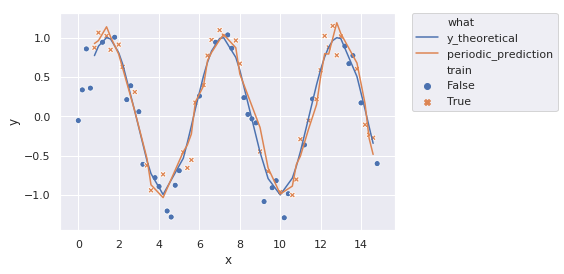

In [0]:
fitter = sklearn.linear_model.Ridge(alpha = 1e-3, normalize=True, fit_intercept=True, solver = 'svd')
model = fitter.fit(dtrain[vars], dtrain['y'])
dtrain['periodic_prediction'] = model.predict(dtrain[vars])
plotf(d, dtrain, ["y_theoretical", "periodic_prediction"])

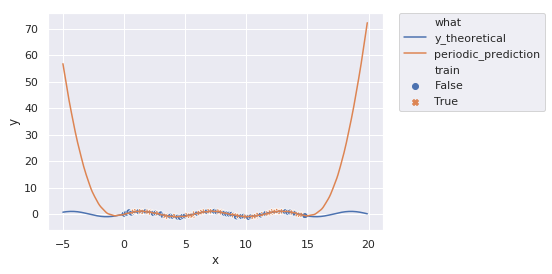

In [0]:
fitter = sklearn.linear_model.Ridge(alpha = 1e-10, normalize=True, fit_intercept=True, solver = 'svd')
model = fitter.fit(dtrain[vars], dtrain['y'])
dexpanded['periodic_prediction'] = model.predict(dexpanded[vars])
plotf(d, dexpanded, ["y_theoretical", "periodic_prediction"])

Better fitting idea

In [0]:
def mk_split_plan(n):
    mid = n/2
    p1 = [ { "train"  : [i for i in range(n) if i>=n/2],
               "test" : [i for i in range(n) if i<n/2] }  ]
    p2 = [ { "train"  : [i for i in range(n) if i<=n/2],
               "test" : [i for i in range(n) if i>n/2] }  ]
    return(p1 + p2)

mk_split_plan(20)

[{'test': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  'train': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
 {'test': [11, 12, 13, 14, 15, 16, 17, 18, 19],
  'train': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]

In [0]:
plan = mk_split_plan(dtrain.shape[0])

alphas = [ 10 ** k for k in range(-3, 3, 1) ]

for alpha in alphas:
    fitter = sklearn.linear_model.Ridge(alpha = alpha, normalize=True, fit_intercept=True, solver = 'svd')
    preds = cross_predict_model(fitter, dtrain[vars], dtrain['y'], plan)
    mean_sq_error = numpy.mean((dtrain['y'] - preds)**2)
    print("alpha " + str(alpha) + " " + str(mean_sq_error))



alpha 0.001 4.066306517981724
alpha 0.01 2.7296654936164546
alpha 0.1 1.3218608879020854
alpha 1 0.5249161693800748
alpha 10 0.7170515203387464
alpha 100 0.593056109866459


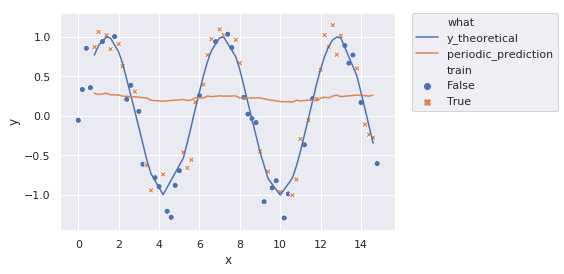

In [0]:
fitter = sklearn.linear_model.Ridge(alpha = 100, normalize=True, fit_intercept=True, solver = 'svd')
model = fitter.fit(dtrain[vars], dtrain['y'])
dtrain['periodic_prediction'] = model.predict(dtrain[vars])
plotf(d, dtrain, ["y_theoretical", "periodic_prediction"])

In [0]:
vars

['sin((x+-0.1)*0.1)',
 'sin((x+-0.05)*0.1)',
 'sin((x+-0.025)*0.1)',
 'sin((x+0.0)*0.1)',
 'sin((x+0.025)*0.1)',
 'sin((x+0.05)*0.1)',
 'sin((x+0.1)*0.1)',
 'sin((x+-0.25)*0.25)',
 'sin((x+-0.125)*0.25)',
 'sin((x+-0.0625)*0.25)',
 'sin((x+0.0)*0.25)',
 'sin((x+0.0625)*0.25)',
 'sin((x+0.125)*0.25)',
 'sin((x+0.25)*0.25)',
 'sin((x+-0.5)*0.5)',
 'sin((x+-0.25)*0.5)',
 'sin((x+-0.125)*0.5)',
 'sin((x+0.0)*0.5)',
 'sin((x+0.125)*0.5)',
 'sin((x+0.25)*0.5)',
 'sin((x+0.5)*0.5)',
 'sin((x+-1.0)*1.0)',
 'sin((x+-0.5)*1.0)',
 'sin((x+-0.25)*1.0)',
 'sin((x+0.0)*1.0)',
 'sin((x+0.25)*1.0)',
 'sin((x+0.5)*1.0)',
 'sin((x+1.0)*1.0)',
 'sin((x+-2.0)*2.0)',
 'sin((x+-1.0)*2.0)',
 'sin((x+-0.5)*2.0)',
 'sin((x+0.0)*2.0)',
 'sin((x+0.5)*2.0)',
 'sin((x+1.0)*2.0)',
 'sin((x+2.0)*2.0)',
 'sin((x+-4)*4)',
 'sin((x+-2.0)*4)',
 'sin((x+-1.0)*4)',
 'sin((x+0)*4)',
 'sin((x+1.0)*4)',
 'sin((x+2.0)*4)',
 'sin((x+4)*4)',
 'sin((x+-10)*10)',
 'sin((x+-5.0)*10)',
 'sin((x+-2.5)*10)',
 'sin((x+0)*10)',
 'sin((

In [0]:
model.coef_

array([-0.00307955, -0.00310213, -0.00311354, -0.00312504, -0.00313663,
       -0.0031483 , -0.00317193, -0.00258877, -0.00239954, -0.00230714,
       -0.00221647, -0.00212769, -0.0020409 , -0.00187371,  0.0001147 ,
        0.0003973 ,  0.0005333 ,  0.00066332,  0.00078581,  0.00089958,
        0.00109799, -0.00164071,  0.00224817,  0.00405254,  0.00572976,
        0.00720566,  0.00834199,  0.00887507,  0.00011726, -0.00125903,
       -0.000312  ,  0.00106952,  0.0013269 ,  0.00049327, -0.0013747 ,
        0.00078045, -0.00092743,  0.00112121, -0.00051369, -0.00040065,
        0.00109621,  0.00021341,  0.00068468,  0.00133864,  0.00163441,
        0.00190474,  0.00214614,  0.00235497,  0.0026595 ])

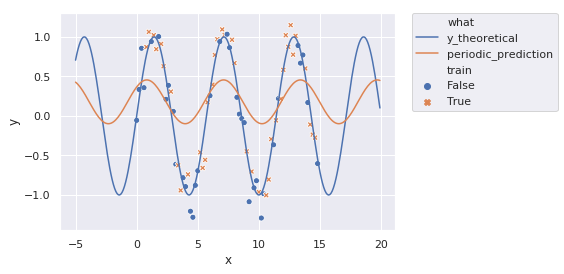

In [0]:
fitter = sklearn.linear_model.ElasticNet(alpha = 0.5, l1_ratio = 0.5, fit_intercept=True)
model = fitter.fit(dtrain[vars], dtrain['y'])
dexpanded['periodic_prediction'] = model.predict(dexpanded[vars])
plotf(d, dexpanded, ["y_theoretical", "periodic_prediction"])

In [0]:
model.coef_

array([-0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.01270626,  0.12824514,  0.14605522,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
    
    1 / (2 * n_samples) * ||y - Xw||^2_2
     + alpha * l1_ratio * ||w||_1
     + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

In [0]:
alphas = [ 10 ** k for k in range(-3, 3, 1) ]
l1_ratios = numpy.arange(0, 1, 0.1)
grid = [ [ {"alpha": alpha, "l1_ratio": l1_ratio} for alpha in alphas ] for l1_ratio in l1_ratios ]
grid = functools.reduce(operator.concat, grid)

def est_quality(settings, plan):
    fitter = sklearn.linear_model.ElasticNet(alpha = settings["alpha"], 
                                             l1_ratio = settings["l1_ratio"], fit_intercept=True)
    preds = cross_predict_model(fitter, dtrain[vars], dtrain['y'], plan)
    mean_sq_error = numpy.mean((dtrain['y'] - preds)**2)
    return(mean_sq_error)
    
param_evals = [ {"settings" : settings, "loss" : est_quality(settings, plan)} for settings in grid ]

min_loss = numpy.min([ q["loss"] for q in param_evals ])

best_params = [ q for q in param_evals if q["loss"] <= min_loss + 1e-9 ]
best_params

[{'loss': 0.30827065452337815, 'settings': {'alpha': 0.1, 'l1_ratio': 0.9}}]

In [0]:
settings = best_params[0]["settings"]
fitter = sklearn.linear_model.ElasticNet(alpha = settings["alpha"], l1_ratio = settings["l1_ratio"], fit_intercept=True)
model = fitter.fit(dtrain[vars], dtrain['y'])
dexpanded['periodic_prediction'] = model.predict(dexpanded[vars])
plotf(d, dexpanded, ["y_theoretical", "periodic_prediction"])

In [0]:
model.coef_

array([-0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.30843575,  0.43240539,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

Let's retry that with the original (not structred/smart) random cross validation.

In [0]:
plan = mk_cross_plan(dtrain.shape[0], 5)

param_evals = [ {"settings" : settings, "loss" : est_quality(settings, plan)} for settings in grid ]

min_loss = numpy.min([ q["loss"] for q in param_evals ])

best_params = [ q for q in param_evals if q["loss"] <= min_loss + 1e-9 ]
best_params

[{'settings': {'alpha': 0.001, 'l1_ratio': 0.0}, 'loss': 0.0807358614832948}]

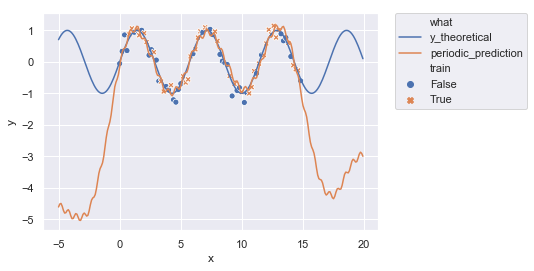

In [0]:
settings = best_params[0]["settings"]
fitter = sklearn.linear_model.ElasticNet(alpha = settings["alpha"], l1_ratio = settings["l1_ratio"], fit_intercept=True)
model = fitter.fit(dtrain[vars], dtrain['y'])
dexpanded['periodic_prediction'] = model.predict(dexpanded[vars])
plotf(d, dexpanded, ["y_theoretical", "periodic_prediction"])